In [1]:
import os
os.chdir('/home/jupyter-nafisha/X-ray-covariates/main')

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path= '/home/jupyter-nafisha/X-ray-covariates/main/best_model.pth'

In [3]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
from dataset.cxr_dataset import CXRMulitmodalDataset
from models.multimodal_cnn import MultimodalCNN
from utils.transforms import get_train_transform, get_val_transform

In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

# from utils.transforms import get_train_transform
from utils.encoders import encode_view, encode_sex

class CXRMulitmodalDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transforms = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row["image_id"]
        img_path = os.path.join(self.img_dir, image_id)
        print(img_path)
        image = Image.open(img_path).convert("RGB")

        if self.transforms:
            image = self.transforms(image)
        
        view = encode_view(row['orientation'])
        sex = encode_sex(row['sex'])
        
        view = torch.tensor(view, dtype=torch.long)
        sex = torch.tensor(sex, dtype=torch.long)
        
        label = 0 if row['label'] == 'Normal' else 1
        label = torch.tensor(label, dtype=torch.float32)
        
        return image, view, sex, label

In [6]:
test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/test.csv'
img_dir = '/home/common/data_v3'

# padchest testing
# test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/PADCHEST_selected_with_reports.csv'
# img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_normalized'
# img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_testing'

device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
def load_model(checkpoint_path, device):
    model = MultimodalCNN()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

model = load_model(checkpoint_path, device)

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-nafisha/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
test_dataset = CXRMulitmodalDataset(test_csv, img_dir, transform=get_val_transform())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Ground-truth labels (Normal=0, Abnormal=1)
# true_labels = test_dataset.df["label"].tolist()
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

In [9]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output
            output.register_hook(self._save_gradients)

        self.target_layer.register_forward_hook(forward_hook)

    def _save_gradients(self, grad):
        self.gradients = grad

    def generate(self, input_tensor, view, sex):
        self.model.zero_grad()

        logits = self.model(input_tensor, view, sex)      # shape: [1, 1]
        score = logits[:, 0]                   # binary logit

        score.backward(retain_graph=True)

        # Grad-CAM formula
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)

        cam = F.relu(cam)
        cam = F.interpolate(
            cam,
            size=input_tensor.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        cam = cam[0, 0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

In [10]:
import torch.nn as nn
def disable_inplace_relu(module):
    if isinstance(module, nn.ReLU):
        module.inplace = False

model.apply(disable_inplace_relu)
model.eval()

MultimodalCNN(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU()
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU()
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU()
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_

In [11]:
def overlay_heatmap(cam, image, alpha=0.3):
    """
    cam: numpy array [H, W] in range [0,1]
    image: torch tensor [1, 3, H, W]
    """
    img = image.squeeze().permute(1, 2, 0).cpu().numpy()

    # normalize image to [0,255]
    img = (img - img.min()) / (img.max() - img.min())
    img = np.uint8(255 * img)

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return overlay

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# target_layer = model.backbone.features.norm5
target_layer = model.backbone.features.denseblock4
gradcam = GradCAM(model, target_layer)

for i in range(10):
    image, view, sex, label = test_dataset[i]
    
    label = label.item()
    image = image.unsqueeze(0).to(device)
    view = view.unsqueeze(0).to(device)
    sex = sex.unsqueeze(0).to(device)

    print(view, sex)

    # ---- Forward (NO torch.no_grad) ----
    logits = model(image, view, sex)
    prob = torch.sigmoid(logits).item()
    pred = int(prob > 0.5)

    # label_map = {0: "Normal", 1: "Abnormal"}
    # print(f"Prediction: {label_map[pred]}, Actual: {label_map[label]}, Prob: {prob:.4f}")

    # # ---- Grad-CAM ----
    # cam = gradcam.generate(image, view, sex)
    # heatmap_overlay = overlay_heatmap(cam, image)
    # print(heatmap_overlay.shape)

    # plt.subplot(1, 2, 2)
    # plt.imshow(heatmap_overlay)
    # plt.title("Original + Grad-CAM")
    # plt.axis("off")

    # plt.tight_layout()
    # plt.show()

/home/common/data_v3/chexpert/patient20327/study1/view2_lateral.jpg
tensor([2], device='cuda:0') tensor([0], device='cuda:0')
/home/common/data_v3/vinbig/a8e2f097cccbf9fd65c69988fe0dd180.jpg
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
/home/common/data_v3/vinbig/5f4eff3b76151906fe87be784d191a1f.jpg
tensor([0], device='cuda:0') tensor([1], device='cuda:0')
/home/common/data_v3/chexpert/patient41165/study9/view1_frontal.jpg
tensor([1], device='cuda:0') tensor([0], device='cuda:0')
/home/common/data_v3/chexpert/patient16357/study1/view1_frontal.jpg
tensor([0], device='cuda:0') tensor([0], device='cuda:0')
/home/common/data_v3/chexpert/patient48198/study2/view1_frontal.jpg
tensor([1], device='cuda:0') tensor([0], device='cuda:0')
/home/common/data_v3/chexpert/patient51361/study1/view1_frontal.jpg
tensor([1], device='cuda:0') tensor([0], device='cuda:0')
/home/common/data_v3/chexpert/patient21344/study14/view1_frontal.jpg
tensor([0], device='cuda:0') tensor([1], device='cuda:0

# using captum

In [24]:
from captum.attr import LayerGradCam

image_path = '/home/common/data_v3/chexpert/patient20327/study1/view2_lateral.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

image_path = '/home/common/data_v3/chexpert/patient00013/study1/view1_frontal.jpg'
view = torch.tensor([0]).to(device)   
sex  = torch.tensor([0]).to(device) 

transform=get_val_transform()

image = Image.open(image_path).convert("RGB")
# image = np.array(image)
augmented_image = transform(image)
image_tensor = augmented_image.unsqueeze(0).to(device)

# Choose final conv layer in DenseNet201 (last layer in last dense block)
target_layer = model.backbone.features.denseblock4
gradcam = LayerGradCam(model, target_layer)

# Get Grad-CAM attribution for regression output
attribution = gradcam.attribute(image_tensor, target=0, additional_forward_args=(view, sex))
attr_map = attribution.squeeze().detach().cpu().numpy()

In [25]:
attr_map = np.maximum(attr_map, 0)  # ReLU (important)
attr_map = attr_map / (attr_map.max() + 1e-8)

# Resize to model input size (224x224)
heatmap = cv2.resize(attr_map, (224, 224))

# Convert tensor to numpy
img_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

# Undo normalization (ImageNet)
mean = np.array([0.485, 0.485, 0.485])
std = np.array([0.229, 0.229, 0.229])
img_np = (img_np * std) + mean
img_np = np.clip(img_np, 0, 1)


heatmap_color = cv2.applyColorMap(
    np.uint8(255 * heatmap),
    cv2.COLORMAP_JET
)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
heatmap_color = heatmap_color / 255.0

overlay = 0.5 * img_np + 0.5 * heatmap_color
overlay = np.clip(overlay, 0, 1)

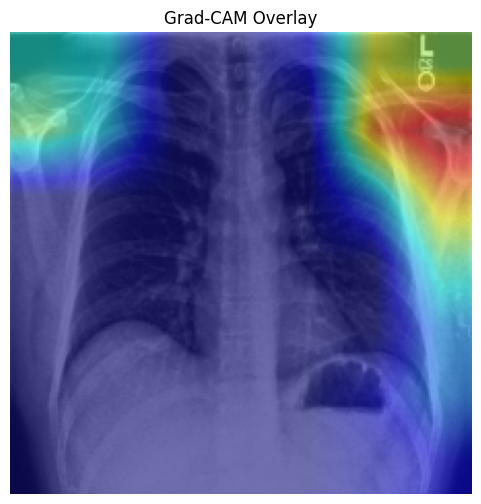

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM Overlay")
plt.show()